In [1]:
import torch
import pandas as pd
import numpy as np
import os
import sys
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
sys.path.append('../')
from util.base_dataset import FaceEdgeFolder
from baselines.models.C3D.C3D_model import C3DVidPredNet
import baselines.models.C3D.networks as network

In [4]:
Epoch = 2000
BatchSize = 4
ImgSize = (384, 256)
Shuffle = True
NumWorkers = 4
UseLsgan = True

In [5]:
df = pd.read_csv('../dataset/emotion_id.csv')
train_dataset = FaceEdgeFolder('../dataset/face_landmark/train_edges_img/', df, samp_len=7,
                        transform=transforms.Compose((transforms.Resize(ImgSize),
                                                     transforms.ToTensor())) )
dataloader = DataLoader(train_dataset, batch_size=BatchSize,
                       shuffle=Shuffle, num_workers=NumWorkers)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tensor_type = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
model = C3DVidPredNet()
disc_model = network.define_D_patch(8, 64, 3, gpu_ids=[0])
model.to(device)

dist_loss = nn.L1Loss()
GAN_loss = network.GANLoss(UseLsgan, tensor=tensor_type)
optimizer_G = torch.optim.Adam(model.parameters())
optimizer_D = torch.optim.Adam(disc_model.parameters())

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(8, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)


In [17]:
model.train()
optimizer_G = torch.optim.Adam(model.parameters(), 1e-4)
optimizer_D = torch.optim.Adam(disc_model.parameters(), 1e-4)
with torch.set_grad_enabled(True):
    for epoch in range(Epoch):
        print("Epoch {}/{}".format(epoch+1, Epoch))
        print('-' * 10)
        
        running_loss = 0.0
        for i, samp in enumerate(dataloader):
            train_img = samp['first_img'].to(device)
            true_tensor = samp['succeed_imgs'].to(device)
            emotion_label = samp['emotion_label'].to(device)
            condition_label = torch.ones((*ImgSize, BatchSize)).to(device) * emotion_label.float() / 100
            condition_label = condition_label.view(BatchSize, 1, 1, *ImgSize)
            input_tensor = torch.cat((train_img, condition_label), dim = 1)

            model.zero_grad()
            pred_tensor = model(input_tensor)
            
            fake_pairs = torch.cat((pred_tensor.squeeze(1).detach(), input_tensor.squeeze(2)), dim=1)
            pred_fake_pool = disc_model(fake_pairs)
            loss_D_fake = GAN_loss(pred_fake_pool, False)
            
            true_pairs = torch.cat((true_tensor.squeeze(1), input_tensor.squeeze(2)), dim=1)
            pred_true = disc_model(true_pairs)
            loss_D_real = GAN_loss(pred_true, True)
            
            fake_true_pairs = torch.cat((pred_tensor.squeeze(1), input_tensor.squeeze(2)), dim=1)
            pred_fake = disc_model(fake_true_pairs)
            loss_G_C3D = GAN_loss(pred_fake, True)
            
            loss_dist = dist_loss(pred_tensor, true_tensor) * 2
            
            loss_D = (loss_D_fake + loss_D_real) * 0.5
            loss_G = loss_G_C3D + loss_dist

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
            
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
            
            if i % 2 == 0:
                print('loss D_real: {:.3f}, loss D_fake: {:.3f}, loss G: {:.3f}, mse loss: {:.3f}' \
                      .format(loss_D_real, loss_D_fake, loss_G_C3D, loss_dist))
            

Epoch 1/2000
----------
loss D_real: 0.006, loss D_fake: 0.012, loss G: 0.898, mse loss: 0.133
loss D_real: 0.034, loss D_fake: 0.098, loss G: 0.505, mse loss: 0.108
loss D_real: 0.153, loss D_fake: 0.052, loss G: 1.158, mse loss: 0.120
loss D_real: 0.108, loss D_fake: 0.044, loss G: 0.786, mse loss: 0.117
loss D_real: 0.039, loss D_fake: 0.079, loss G: 0.786, mse loss: 0.133
loss D_real: 0.074, loss D_fake: 0.165, loss G: 0.491, mse loss: 0.142
loss D_real: 0.074, loss D_fake: 0.200, loss G: 0.376, mse loss: 0.138
loss D_real: 0.037, loss D_fake: 0.078, loss G: 0.711, mse loss: 0.140
loss D_real: 0.582, loss D_fake: 0.073, loss G: 0.621, mse loss: 0.134
loss D_real: 0.121, loss D_fake: 0.037, loss G: 1.142, mse loss: 0.163
loss D_real: 0.028, loss D_fake: 0.024, loss G: 1.106, mse loss: 0.132
loss D_real: 0.039, loss D_fake: 0.037, loss G: 1.204, mse loss: 0.129
loss D_real: 0.062, loss D_fake: 0.167, loss G: 0.432, mse loss: 0.136
loss D_real: 0.031, loss D_fake: 0.096, loss G: 0.536

loss D_real: 0.071, loss D_fake: 0.064, loss G: 0.616, mse loss: 0.121
loss D_real: 0.039, loss D_fake: 0.088, loss G: 0.543, mse loss: 0.136
loss D_real: 0.263, loss D_fake: 0.083, loss G: 0.591, mse loss: 0.133
loss D_real: 0.011, loss D_fake: 0.066, loss G: 0.614, mse loss: 0.112
loss D_real: 0.008, loss D_fake: 0.022, loss G: 0.796, mse loss: 0.173
loss D_real: 0.118, loss D_fake: 0.009, loss G: 0.985, mse loss: 0.120
loss D_real: 0.222, loss D_fake: 0.087, loss G: 0.548, mse loss: 0.136
loss D_real: 0.208, loss D_fake: 0.034, loss G: 0.755, mse loss: 0.157
loss D_real: 0.014, loss D_fake: 0.127, loss G: 0.446, mse loss: 0.134
loss D_real: 0.060, loss D_fake: 0.151, loss G: 0.402, mse loss: 0.128
loss D_real: 0.024, loss D_fake: 0.044, loss G: 0.709, mse loss: 0.134
loss D_real: 0.229, loss D_fake: 0.048, loss G: 0.719, mse loss: 0.148
loss D_real: 0.069, loss D_fake: 0.020, loss G: 0.899, mse loss: 0.133
loss D_real: 0.121, loss D_fake: 0.028, loss G: 1.048, mse loss: 0.159
loss D

loss D_real: 0.058, loss D_fake: 0.024, loss G: 0.791, mse loss: 0.132
loss D_real: 0.244, loss D_fake: 0.041, loss G: 0.750, mse loss: 0.128
loss D_real: 0.060, loss D_fake: 0.086, loss G: 0.550, mse loss: 0.153
loss D_real: 0.033, loss D_fake: 0.090, loss G: 0.535, mse loss: 0.124
loss D_real: 0.033, loss D_fake: 0.024, loss G: 0.786, mse loss: 0.145
loss D_real: 0.121, loss D_fake: 0.037, loss G: 0.728, mse loss: 0.134
loss D_real: 0.728, loss D_fake: 0.024, loss G: 0.791, mse loss: 0.130
loss D_real: 0.013, loss D_fake: 0.093, loss G: 0.531, mse loss: 0.134
loss D_real: 0.064, loss D_fake: 0.208, loss G: 0.340, mse loss: 0.145
loss D_real: 0.014, loss D_fake: 0.073, loss G: 0.589, mse loss: 0.137
loss D_real: 0.060, loss D_fake: 0.072, loss G: 0.748, mse loss: 0.135
loss D_real: 0.263, loss D_fake: 0.029, loss G: 0.858, mse loss: 0.148
loss D_real: 0.103, loss D_fake: 0.072, loss G: 0.597, mse loss: 0.144
loss D_real: 0.074, loss D_fake: 0.257, loss G: 0.317, mse loss: 0.147
Epoch 

loss D_real: 0.007, loss D_fake: 0.009, loss G: 0.970, mse loss: 0.131
loss D_real: 0.008, loss D_fake: 0.022, loss G: 0.805, mse loss: 0.143
loss D_real: 0.041, loss D_fake: 0.050, loss G: 0.699, mse loss: 0.138
loss D_real: 0.285, loss D_fake: 0.299, loss G: 0.238, mse loss: 0.102
loss D_real: 0.057, loss D_fake: 0.184, loss G: 0.353, mse loss: 0.128
loss D_real: 0.022, loss D_fake: 0.095, loss G: 0.609, mse loss: 0.130
loss D_real: 0.036, loss D_fake: 0.072, loss G: 0.671, mse loss: 0.112
loss D_real: 0.024, loss D_fake: 0.016, loss G: 0.910, mse loss: 0.114
loss D_real: 0.042, loss D_fake: 0.032, loss G: 1.272, mse loss: 0.124
loss D_real: 0.068, loss D_fake: 0.043, loss G: 0.890, mse loss: 0.118
Epoch 17/2000
----------
loss D_real: 0.018, loss D_fake: 0.020, loss G: 0.922, mse loss: 0.117
loss D_real: 0.015, loss D_fake: 0.035, loss G: 0.746, mse loss: 0.123
loss D_real: 0.027, loss D_fake: 0.098, loss G: 0.504, mse loss: 0.113
loss D_real: 0.098, loss D_fake: 0.123, loss G: 0.46

loss D_real: 0.007, loss D_fake: 0.015, loss G: 0.878, mse loss: 0.137
loss D_real: 0.007, loss D_fake: 0.157, loss G: 0.387, mse loss: 0.143
loss D_real: 0.150, loss D_fake: 0.123, loss G: 0.450, mse loss: 0.114
loss D_real: 0.528, loss D_fake: 0.013, loss G: 0.888, mse loss: 0.144
loss D_real: 0.010, loss D_fake: 0.038, loss G: 0.701, mse loss: 0.122
loss D_real: 0.131, loss D_fake: 0.034, loss G: 0.717, mse loss: 0.148
Epoch 22/2000
----------
loss D_real: 0.066, loss D_fake: 0.051, loss G: 0.642, mse loss: 0.114
loss D_real: 0.619, loss D_fake: 0.030, loss G: 0.728, mse loss: 0.121
loss D_real: 0.593, loss D_fake: 0.452, loss G: 0.121, mse loss: 0.127
loss D_real: 0.011, loss D_fake: 0.058, loss G: 0.639, mse loss: 0.125
loss D_real: 0.011, loss D_fake: 0.048, loss G: 0.681, mse loss: 0.114
loss D_real: 0.040, loss D_fake: 0.011, loss G: 1.080, mse loss: 0.134
loss D_real: 0.052, loss D_fake: 0.216, loss G: 0.309, mse loss: 0.142
loss D_real: 1.269, loss D_fake: 0.044, loss G: 1.41

loss D_real: 0.040, loss D_fake: 0.104, loss G: 0.505, mse loss: 0.151
loss D_real: 0.021, loss D_fake: 0.083, loss G: 0.556, mse loss: 0.139
Epoch 27/2000
----------
loss D_real: 0.020, loss D_fake: 0.125, loss G: 0.474, mse loss: 0.143
loss D_real: 0.008, loss D_fake: 0.062, loss G: 0.613, mse loss: 0.121
loss D_real: 0.527, loss D_fake: 0.059, loss G: 0.716, mse loss: 0.132
loss D_real: 0.017, loss D_fake: 0.063, loss G: 0.679, mse loss: 0.140
loss D_real: 0.009, loss D_fake: 0.079, loss G: 0.551, mse loss: 0.141
loss D_real: 0.020, loss D_fake: 0.097, loss G: 0.592, mse loss: 0.144
loss D_real: 0.500, loss D_fake: 0.049, loss G: 0.720, mse loss: 0.120
loss D_real: 0.006, loss D_fake: 0.079, loss G: 0.551, mse loss: 0.120
loss D_real: 0.039, loss D_fake: 0.071, loss G: 0.606, mse loss: 0.138
loss D_real: 0.007, loss D_fake: 0.097, loss G: 0.506, mse loss: 0.119
loss D_real: 0.006, loss D_fake: 0.178, loss G: 0.350, mse loss: 0.133
loss D_real: 0.629, loss D_fake: 0.057, loss G: 0.65

loss D_real: 0.022, loss D_fake: 0.087, loss G: 0.533, mse loss: 0.134
loss D_real: 0.276, loss D_fake: 0.061, loss G: 0.658, mse loss: 0.091
loss D_real: 0.011, loss D_fake: 0.115, loss G: 0.473, mse loss: 0.137
loss D_real: 0.007, loss D_fake: 0.120, loss G: 0.449, mse loss: 0.110
loss D_real: 0.010, loss D_fake: 0.082, loss G: 0.553, mse loss: 0.120
loss D_real: 0.017, loss D_fake: 0.014, loss G: 0.862, mse loss: 0.122
loss D_real: 0.049, loss D_fake: 0.013, loss G: 0.904, mse loss: 0.131
loss D_real: 0.040, loss D_fake: 0.035, loss G: 0.700, mse loss: 0.136
loss D_real: 0.024, loss D_fake: 0.019, loss G: 1.082, mse loss: 0.133
loss D_real: 0.026, loss D_fake: 0.028, loss G: 0.902, mse loss: 0.137
loss D_real: 0.008, loss D_fake: 0.055, loss G: 0.631, mse loss: 0.120
loss D_real: 0.014, loss D_fake: 0.055, loss G: 0.645, mse loss: 0.120
loss D_real: 0.250, loss D_fake: 0.120, loss G: 0.504, mse loss: 0.123
loss D_real: 0.028, loss D_fake: 0.082, loss G: 0.569, mse loss: 0.164
loss D

loss D_real: 0.024, loss D_fake: 0.030, loss G: 0.857, mse loss: 0.119
loss D_real: 0.023, loss D_fake: 0.027, loss G: 0.813, mse loss: 0.130
loss D_real: 0.607, loss D_fake: 0.014, loss G: 0.990, mse loss: 0.102
loss D_real: 0.015, loss D_fake: 0.072, loss G: 0.592, mse loss: 0.121
loss D_real: 0.009, loss D_fake: 0.352, loss G: 0.188, mse loss: 0.093
loss D_real: 0.006, loss D_fake: 0.317, loss G: 0.204, mse loss: 0.129
loss D_real: 0.930, loss D_fake: 0.034, loss G: 0.999, mse loss: 0.116
loss D_real: 0.027, loss D_fake: 0.145, loss G: 0.528, mse loss: 0.106
loss D_real: 0.195, loss D_fake: 0.058, loss G: 0.657, mse loss: 0.133
loss D_real: 0.061, loss D_fake: 0.268, loss G: 0.275, mse loss: 0.114
loss D_real: 0.084, loss D_fake: 0.166, loss G: 0.388, mse loss: 0.150
loss D_real: 0.336, loss D_fake: 0.165, loss G: 0.381, mse loss: 0.137
loss D_real: 0.306, loss D_fake: 0.110, loss G: 0.480, mse loss: 0.117
loss D_real: 0.020, loss D_fake: 0.136, loss G: 0.435, mse loss: 0.157
loss D

loss D_real: 0.413, loss D_fake: 0.016, loss G: 0.838, mse loss: 0.128
loss D_real: 0.012, loss D_fake: 0.087, loss G: 0.544, mse loss: 0.100
loss D_real: 0.256, loss D_fake: 0.030, loss G: 0.729, mse loss: 0.132
loss D_real: 0.024, loss D_fake: 0.101, loss G: 0.501, mse loss: 0.130
loss D_real: 0.308, loss D_fake: 0.013, loss G: 0.880, mse loss: 0.127
loss D_real: 0.297, loss D_fake: 0.458, loss G: 0.116, mse loss: 0.100
loss D_real: 0.014, loss D_fake: 0.240, loss G: 0.278, mse loss: 0.108
loss D_real: 0.021, loss D_fake: 0.306, loss G: 0.221, mse loss: 0.135
loss D_real: 0.196, loss D_fake: 0.017, loss G: 1.066, mse loss: 0.116
loss D_real: 0.028, loss D_fake: 0.082, loss G: 0.549, mse loss: 0.132
loss D_real: 0.018, loss D_fake: 0.138, loss G: 0.446, mse loss: 0.137
loss D_real: 0.050, loss D_fake: 0.096, loss G: 0.531, mse loss: 0.130
Epoch 43/2000
----------
loss D_real: 0.353, loss D_fake: 0.064, loss G: 0.628, mse loss: 0.120
loss D_real: 0.025, loss D_fake: 0.150, loss G: 0.42

loss D_real: 0.814, loss D_fake: 0.019, loss G: 0.879, mse loss: 0.155
loss D_real: 0.565, loss D_fake: 0.043, loss G: 0.715, mse loss: 0.134
loss D_real: 0.529, loss D_fake: 0.070, loss G: 0.613, mse loss: 0.138
loss D_real: 0.442, loss D_fake: 0.126, loss G: 0.491, mse loss: 0.101
loss D_real: 0.016, loss D_fake: 0.171, loss G: 0.380, mse loss: 0.100
loss D_real: 0.040, loss D_fake: 0.167, loss G: 0.461, mse loss: 0.129
loss D_real: 0.352, loss D_fake: 0.090, loss G: 0.595, mse loss: 0.125
loss D_real: 0.012, loss D_fake: 0.032, loss G: 0.782, mse loss: 0.122
Epoch 48/2000
----------
loss D_real: 0.041, loss D_fake: 0.044, loss G: 0.767, mse loss: 0.111
loss D_real: 0.050, loss D_fake: 0.056, loss G: 0.723, mse loss: 0.125
loss D_real: 0.213, loss D_fake: 0.015, loss G: 0.932, mse loss: 0.125
loss D_real: 0.319, loss D_fake: 0.022, loss G: 0.899, mse loss: 0.110
loss D_real: 0.014, loss D_fake: 0.074, loss G: 0.568, mse loss: 0.119
loss D_real: 0.026, loss D_fake: 0.111, loss G: 0.47

loss D_real: 0.019, loss D_fake: 0.030, loss G: 0.767, mse loss: 0.130
loss D_real: 0.022, loss D_fake: 0.037, loss G: 0.722, mse loss: 0.116
loss D_real: 0.014, loss D_fake: 0.040, loss G: 0.696, mse loss: 0.124
loss D_real: 0.046, loss D_fake: 0.019, loss G: 1.176, mse loss: 0.116
Epoch 53/2000
----------
loss D_real: 0.160, loss D_fake: 0.013, loss G: 0.953, mse loss: 0.161
loss D_real: 0.047, loss D_fake: 0.014, loss G: 0.915, mse loss: 0.109
loss D_real: 0.845, loss D_fake: 0.025, loss G: 0.772, mse loss: 0.127
loss D_real: 0.475, loss D_fake: 0.035, loss G: 0.727, mse loss: 0.120
loss D_real: 0.068, loss D_fake: 0.089, loss G: 0.526, mse loss: 0.152
loss D_real: 0.032, loss D_fake: 0.127, loss G: 0.438, mse loss: 0.111
loss D_real: 0.469, loss D_fake: 0.052, loss G: 0.672, mse loss: 0.133
loss D_real: 0.013, loss D_fake: 0.114, loss G: 0.498, mse loss: 0.131
loss D_real: 0.123, loss D_fake: 0.318, loss G: 0.257, mse loss: 0.149
loss D_real: 0.026, loss D_fake: 0.013, loss G: 1.11

Epoch 58/2000
----------
loss D_real: 0.004, loss D_fake: 0.030, loss G: 0.739, mse loss: 0.136
loss D_real: 0.017, loss D_fake: 0.050, loss G: 0.664, mse loss: 0.118
loss D_real: 0.448, loss D_fake: 0.020, loss G: 0.853, mse loss: 0.129
loss D_real: 0.010, loss D_fake: 0.079, loss G: 0.554, mse loss: 0.121
loss D_real: 0.010, loss D_fake: 0.289, loss G: 0.240, mse loss: 0.128
loss D_real: 0.031, loss D_fake: 0.050, loss G: 0.683, mse loss: 0.116
loss D_real: 0.030, loss D_fake: 0.037, loss G: 0.734, mse loss: 0.133
loss D_real: 0.048, loss D_fake: 0.012, loss G: 0.861, mse loss: 0.124
loss D_real: 0.025, loss D_fake: 0.102, loss G: 0.537, mse loss: 0.122
loss D_real: 0.121, loss D_fake: 0.131, loss G: 0.469, mse loss: 0.122
loss D_real: 0.015, loss D_fake: 0.100, loss G: 0.507, mse loss: 0.114
loss D_real: 0.013, loss D_fake: 0.143, loss G: 0.423, mse loss: 0.127
loss D_real: 0.035, loss D_fake: 0.131, loss G: 0.505, mse loss: 0.106
loss D_real: 0.017, loss D_fake: 0.021, loss G: 0.91

loss D_real: 0.024, loss D_fake: 0.044, loss G: 0.715, mse loss: 0.113
loss D_real: 0.005, loss D_fake: 0.010, loss G: 1.018, mse loss: 0.140
loss D_real: 0.804, loss D_fake: 0.012, loss G: 0.948, mse loss: 0.139
loss D_real: 0.025, loss D_fake: 0.096, loss G: 0.531, mse loss: 0.127
loss D_real: 0.118, loss D_fake: 0.146, loss G: 0.458, mse loss: 0.144
loss D_real: 0.025, loss D_fake: 0.110, loss G: 0.486, mse loss: 0.152
loss D_real: 0.025, loss D_fake: 0.091, loss G: 0.579, mse loss: 0.128
loss D_real: 0.233, loss D_fake: 0.031, loss G: 1.107, mse loss: 0.117
loss D_real: 0.897, loss D_fake: 0.023, loss G: 1.136, mse loss: 0.118
loss D_real: 0.308, loss D_fake: 0.109, loss G: 0.506, mse loss: 0.115
loss D_real: 0.061, loss D_fake: 0.050, loss G: 1.096, mse loss: 0.122
loss D_real: 0.023, loss D_fake: 0.030, loss G: 1.000, mse loss: 0.113
loss D_real: 0.013, loss D_fake: 0.022, loss G: 0.965, mse loss: 0.134
loss D_real: 0.062, loss D_fake: 0.034, loss G: 1.003, mse loss: 0.113
loss D

Process Process-951:
Process Process-952:
Process Process-949:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-950:
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/mult

KeyboardInterrupt: 

In [ ]:
true_tensor.squeeze(1).shape

In [8]:
len(train_dataset) * 5

880

In [22]:
input_tensor.shape

torch.Size([4, 2, 1, 384, 256])

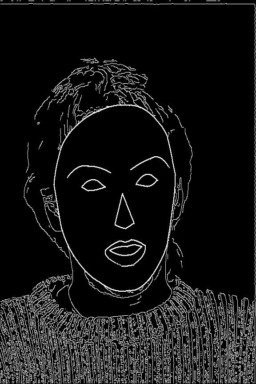

In [10]:
Image.fromarray((input_tensor[0,0,0]*255).cpu().detach().numpy().astype('uint8'), 'L')

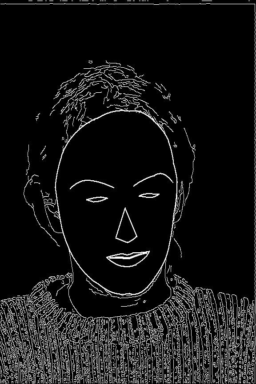

In [11]:
Image.fromarray((true_tensor[0,0,5]*255).cpu().detach().numpy().astype('uint8'), 'L')

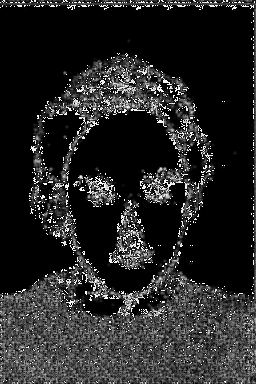

In [18]:
Image.fromarray((pred_tensor[0,0,1]*255).cpu().detach().numpy().astype('uint8'), 'L')

In [13]:
torch.cat((condition_label.view(BatchSize, 1, 1, *ImgSize), train_img), dim=1).size()

torch.Size([4, 2, 1, 384, 256])